## 2025_Fall_DL_week5_Homework
8/7 CNN 실습 예제코드입니다!

이번 5주차 숙제는 총 2가지로 구성되어 있습니다.
- 논문 리뷰 - ResNet : https://arxiv.org/abs/1512.03385


    다음 논문을 읽고 4분이서 의견 공유 및 리뷰 발표를 준비해주시면 됩니다! (발표자, 자료, 시간 등 제약은 없으나, 1~2명이서 약 5분~10분정도로 notion이나 word를 이용하여 작성 후 pdf로 변환해서 깃허브에 제출해 주시는걸 추천합니다!) 

- 코드 구현 - CNN

    아래 실습코드를 그대로 참고하셔도 좋고, 새롭게 짜셔도 좋습니다. 데이터셋은 CIFAR10이 아닌 벤치마크(MNIST, FFHQ, ImageNet)이나 다른 데이터셋을 사용하되, 학습 시간 및 리소스를 적절히 사용할 수 있는 화질을 사용하는 것을 추천 드립니다. 또한, 앞서 배운 regularization, initialization, optimizer 등등 기법을 추가해보시거나, layer를 변형하는 시도를 추가하여 결과를 분석해주세요. (스터디를 통해 각자한 시도가 겹치지 않으면 좋은 경험이 될 것 같습니다!)

    example : Earlystopping 추가, Dropoutlayer 추가, batch nomalization 추가, stride 및 padding 변형, Conv layer 추가 및 삭제 등등

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.adam import Adam
from torch.utils.data.dataloader import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
from tqdm import tqdm

(32, 32, 3)


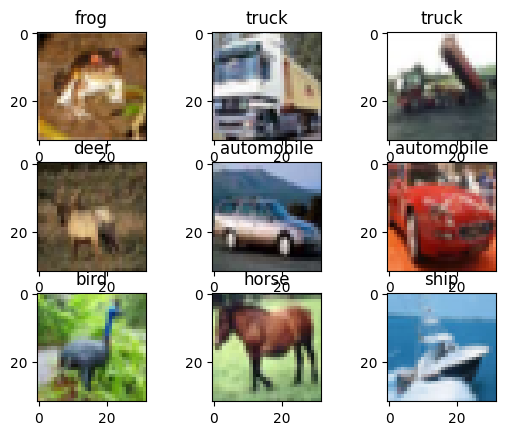

In [3]:
# 데이터셋 정의 -> cifar-10
train_data = datasets.cifar.CIFAR10(
    './data/', 
    train=True, 
    download=True, 
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]))

'''
다음과 같이 정의하여 함수형태로 후처리도 가능합니다

transform=transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data = data_transform(train_data)
'''


test_data = datasets.cifar.CIFAR10(
    root="../data/",
    train=False,
    download=True,
    transform=transforms.ToTensor())

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(train_data.data[i])
    plt.title(train_data.classes[train_data.targets[i]])

print(train_data.data[0].shape)
plt.show()

In [ ]:
from torch.utils.data import Dataset

class CustomCIFAR10(Dataset):
    def __init__(self, root, train=True, download=False):
        # self.base_dataset = dataset.load_dataset(path = '')
        self.base_dataset = datasets.cifar.CIFAR10(
            root=root,
            train=train,
            download=download
        )

        self.train = train

        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(0.5),
            transforms.RandomCrop(32, padding=4),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    def __len__(self):
        return len(self.base_dataset.data)

    def __getitem__(self, idx):
        image = self.base_dataset.data[idx]  # numpy array (H, W, C)
        label = self.base_dataset.targets[idx]

        if self.train:
            image = self.transform(image)

        return image, label

# 인스턴스 생성
train_data = CustomCIFAR10(root='./data/', train=True, download=True)
test_data = CustomCIFAR10(root='./data/', train=False, download=True)

## Modeling

In [ ]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_dim):
        super(BasicBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, hidden_dim, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(hidden_dim, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        '''
        nn.Sequential 로 각 레이어를 묶어서 하나의 모델로 정의할 수도 있습니다!

        self.model = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
        '''
    
    def forward(self, x): 
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        return x

        # return self.model(x)

In [12]:
class CNN(nn.Module):
    def __init__(self, num_classes): # 클래스의 갯수
        super(CNN, self).__init__()
        
        # CNN 블럭 정의
        self.block1 = BasicBlock(in_channels=3, out_channels=32, hidden_dim=16)
        self.block2 = BasicBlock(in_channels=32, out_channels=128, hidden_dim=64)
        self.block3 = BasicBlock(in_channels=128, out_channels=256, hidden_dim=128)
        
        # classification을 위한 FC 정의
        self.fc1 = nn.Linear(in_features=4096, out_features=2048)
        self.fc2 = nn.Linear(in_features=2048, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=num_classes)
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x) # 출력모양: (-1, 256, 4, 4)
        x = torch.flatten(x, start_dim=1) # 2차원의 feature map을 1차원으로
        
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        
        return x

In [13]:
from torch.utils.data.dataloader import DataLoader

from torch.optim.adam import Adam


# 데이터로더 정의
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# 학습을 진행할 프로세서 설정
device = "cuda" if torch.cuda.is_available() else "cpu"


print(f"device 정보: {device}")

# CNN 모델 정의
model = CNN(num_classes=10)

# 모델을 device로 보냄
model.to(device)

device 정보: cuda


CNN(
  (block1): BasicBlock(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): BasicBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): BasicBlock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=4096, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=256,

In [14]:
# Learning rate
lr = 1e-3

# Optimizer
optim = Adam(model.parameters(), lr=lr)

# Train loop
for epoch in range(100):
    for data, label in tqdm(train_loader): # read data
        optim.zero_grad() # Iniitlaization
        
        preds = model(data.to(device)) # prediction
        
        # Loss Function
        loss = nn.CrossEntropyLoss()(preds, label.to(device))
        loss.backward()
        optim.step()
    
    if epoch==0 or epoch%10==9: # 10번마다 손실 출력
        print(f"epoch{epoch+1} loss:{loss.item()}")
        
# 모델 저장
torch.save(model.state_dict(), "CIFAR.pth")

100%|██████████| 782/782 [00:23<00:00, 32.65it/s]


epoch1 loss:1.6459541320800781


100%|██████████| 782/782 [00:23<00:00, 33.27it/s]


epoch10 loss:0.7928268909454346


100%|██████████| 782/782 [00:23<00:00, 32.85it/s]


epoch20 loss:0.225490540266037


100%|██████████| 782/782 [00:23<00:00, 33.61it/s]


epoch30 loss:0.20378458499908447


100%|██████████| 782/782 [00:23<00:00, 33.66it/s]


epoch40 loss:0.3061363995075226


100%|██████████| 782/782 [00:24<00:00, 32.05it/s]


epoch50 loss:0.3115704357624054


100%|██████████| 782/782 [00:23<00:00, 33.55it/s]


epoch60 loss:0.1423719823360443


100%|██████████| 782/782 [00:23<00:00, 33.62it/s]


epoch70 loss:0.001698196749202907


100%|██████████| 782/782 [00:23<00:00, 33.58it/s]


epoch80 loss:0.40285295248031616


100%|██████████| 782/782 [00:23<00:00, 33.66it/s]


epoch90 loss:0.3248620629310608


100%|██████████| 782/782 [00:23<00:00, 33.56it/s]


epoch100 loss:0.09326416254043579


In [15]:
model.load_state_dict(torch.load("CIFAR.pth", map_location=device))

num_corr = 0

with torch.no_grad():
    for data, label in tqdm(test_loader):
        output = model(data.to(device))
        preds = output.data.max(1)[1]
        corr = preds.eq(label.to(device).data).sum().item()
        num_corr += corr

    print(f"Accuracy:{num_corr/len(test_data)}")

100%|██████████| 157/157 [00:04<00:00, 36.56it/s]

Accuracy:0.84


## MNIST 데이터셋

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.optim import Adam
import matplotlib.pyplot as plt
from tqdm import tqdm

# ==== 데이터셋 ====
train_data = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.RandomRotation(10),  # 데이터 증강
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
)

test_data = datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# ==== 모델 ====
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_dim, dropout_p=0.3):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, hidden_dim, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(hidden_dim)
        self.conv2 = nn.Conv2d(hidden_dim, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_p)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        return x

class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        self.block1 = BasicBlock(1, 32, 16)
        self.block2 = BasicBlock(32, 64, 32)
        self.block3 = BasicBlock(64, 128, 64)
        self.fc1 = nn.Linear(128 * 3 * 3, 256)  # MNIST: 28x28 -> (block3) 3x3
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 64)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(64, num_classes)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# ==== 학습 설정 ====
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CNN(num_classes=10).to(device)
optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# Early Stopping
best_acc = 0
patience = 5
trigger = 0

train_acc_list, test_acc_list = [], []

# ==== 학습 ====
for epoch in range(20):
    model.train()
    for data, label in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        data, label = data.to(device), label.to(device)
        optimizer.zero_grad()
        preds = model(data)
        loss = criterion(preds, label)
        loss.backward()
        optimizer.step()


Epoch 20: 100%|███████████████████████████████████| 938/938 [01:18<00:00, 11.97it/s]


## Initialization 실습

Xavier 초기화
He 초기화

[DEFAULT] Epoch 1 - Train: 0.9769, Test: 0.9832
[DEFAULT] Epoch 2 - Train: 0.9830, Test: 0.9870
[DEFAULT] Epoch 3 - Train: 0.9836, Test: 0.9900
[DEFAULT] Epoch 4 - Train: 0.9894, Test: 0.9921
[DEFAULT] Epoch 5 - Train: 0.9877, Test: 0.9917
[DEFAULT] Epoch 6 - Train: 0.9908, Test: 0.9932
[DEFAULT] Epoch 7 - Train: 0.9912, Test: 0.9932
[DEFAULT] Epoch 8 - Train: 0.9929, Test: 0.9940
[DEFAULT] Epoch 9 - Train: 0.9931, Test: 0.9944
[DEFAULT] Epoch 10 - Train: 0.9909, Test: 0.9927
[XAVIER] Epoch 1 - Train: 0.9692, Test: 0.9744
[XAVIER] Epoch 2 - Train: 0.9816, Test: 0.9874
[XAVIER] Epoch 3 - Train: 0.9786, Test: 0.9833
[XAVIER] Epoch 4 - Train: 0.9859, Test: 0.9911
[XAVIER] Epoch 5 - Train: 0.9881, Test: 0.9922
[XAVIER] Epoch 6 - Train: 0.9897, Test: 0.9917
[XAVIER] Epoch 7 - Train: 0.9895, Test: 0.9919
[XAVIER] Epoch 8 - Train: 0.9919, Test: 0.9939
[XAVIER] Epoch 9 - Train: 0.9907, Test: 0.9921
[XAVIER] Epoch 10 - Train: 0.9891, Test: 0.9920
[HE] Epoch 1 - Train: 0.9568, Test: 0.9655
[HE] 

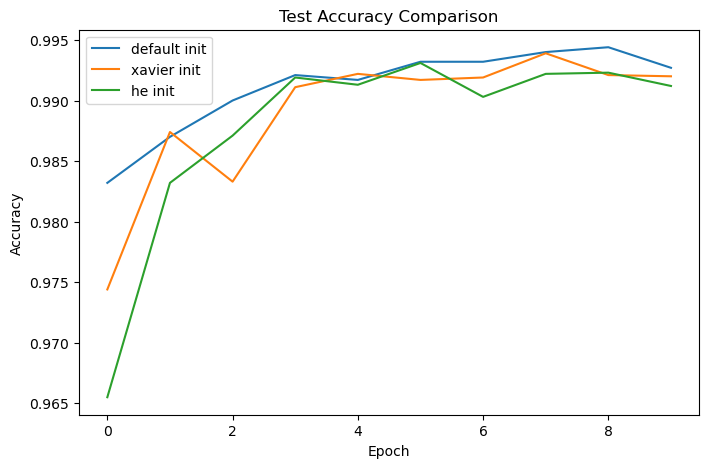

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.optim import Adam
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy

# ==== 데이터셋 ====
train_data = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
)

test_data = datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# ==== 모델 ====
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_dim, dropout_p=0.3):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, hidden_dim, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(hidden_dim)
        self.conv2 = nn.Conv2d(hidden_dim, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_p)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        return x

class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        self.block1 = BasicBlock(1, 32, 16)
        self.block2 = BasicBlock(32, 64, 32)
        self.block3 = BasicBlock(64, 128, 64)
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 64)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(64, num_classes)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# ==== 가중치 초기화 함수 ====
def init_weights(model, method='default'):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            if method == 'xavier':
                nn.init.xavier_uniform_(m.weight)
            elif method == 'he':
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
            else:  # default
                pass
            if m.bias is not None:
                nn.init.zeros_(m.bias)

# ==== 학습 함수 ====
def train_and_evaluate(method):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = CNN().to(device)
    init_weights(model, method)

    optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()

    train_acc_list, test_acc_list = [], []

    for epoch in range(10):  # 간단히 10 epoch만 학습
        model.train()
        for data, label in train_loader:
            data, label = data.to(device), label.to(device)
            optimizer.zero_grad()
            preds = model(data)
            loss = criterion(preds, label)
            loss.backward()
            optimizer.step()

        # 평가
        model.eval()
        correct_train, correct_test = 0, 0
        with torch.no_grad():
            for data, label in train_loader:
                data, label = data.to(device), label.to(device)
                preds = model(data)
                correct_train += (preds.argmax(1) == label).sum().item()
        train_acc = correct_train / len(train_data)

        with torch.no_grad():
            for data, label in test_loader:
                data, label = data.to(device), label.to(device)
                preds = model(data)
                correct_test += (preds.argmax(1) == label).sum().item()
        test_acc = correct_test / len(test_data)

        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(f"[{method.upper()}] Epoch {epoch+1} - Train: {train_acc:.4f}, Test: {test_acc:.4f}")

    return train_acc_list, test_acc_list

# ==== 실행 및 비교 ====
methods = ['default', 'xavier', 'he']
results = {}

for m in methods:
    results[m] = train_and_evaluate(m)

# ==== 그래프 시각화 ====
plt.figure(figsize=(8,5))
for m in methods:
    plt.plot(results[m][1], label=f"{m} init")
plt.title("Test Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
